In [1]:
import sys
sys.path.append('../scripts')

In [2]:
import experimenting
import event_library as el
import torch
from matplotlib import pyplot as plt
from experimenting.utils.visualization import plot_skeleton_2d, plot_skeleton_3d
from experimenting.utils.skeleton_helpers import Skeleton
import numpy as np
from experimenting.dataset.factory import Joints3DConstructor
import experimenting.utils.visualization as viz
import experimenting
from experimenting.utils import utilities

C:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
hw = el.utils.get_hw_property('dvs')

In [ ]:
# Wrapper for Events-H3m
h3mcore = experimenting.dataset.HumanCore('test', '/data/gscarpellini/dataset/human3.6m/constant_count', '/data/gscarpellini/dataset/human3.6m/constant_count/gt.npz', 'cross-view', 1, test_cams=[1, 3], test_subjects=[6, 7])

In [9]:
# Wrapper for DHP19
# dhpcore = experimenting.dataset.DHP19Core('test', base_path='/data/gscarpellini/dhp19/time_count_dataset', data_dir='/data/gscarpellini/dhp19/time_count_dataset/movements_per_frame', joints_dir='/data/gscarpellini/dhp19/time_count_dataset/labels_full_joints', hm_dir="",  labels_dir="", preload_dir="", n_joints=13, n_classes=33, partition='cross-subject', n_channels=1, cams=[1, 3], movements=None, test_subjects=[6, 7])
dhpcore = experimenting.dataset.DHP19Core('test', base_path=r'D:\Dataset\DVS\dhp19\time_count_dataset', data_dir=r'D:\Dataset\DVS\dhp19\time_count_dataset\frames', joints_dir=r'D:\Dataset\DVS\dhp19\time_count_dataset\labels', hm_dir="",  labels_dir="", preload_dir="", n_joints=13, n_classes=33, partition='cross-subject', n_channels=1, cams=[1, 3], movements=None, test_subjects=[6, 7])


In [47]:
# Example using H3m

No handles with labels found to put in legend.


{'subject': 1, 'action': 'Directions 1', 'cam': 0, 'frame': '0000011'}


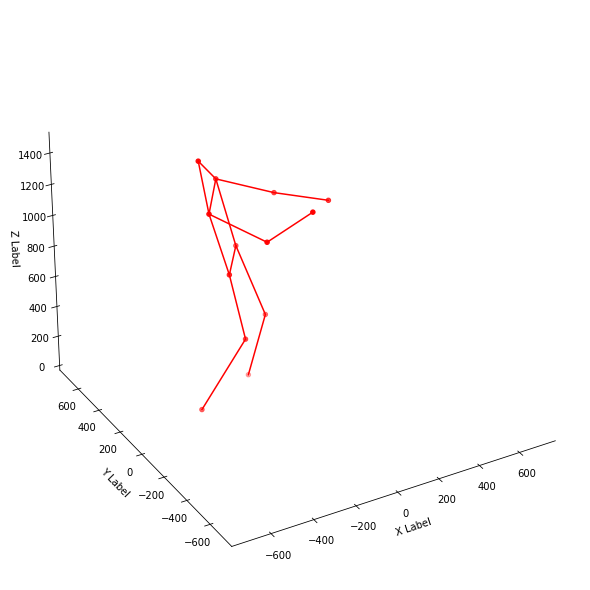

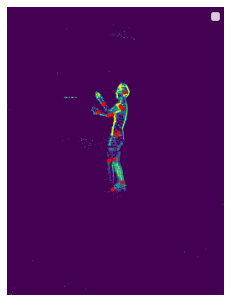

In [65]:
idx = 10
print(h3mcore.frames_info[idx+1])
sk, intr, extr = h3mcore.get_joint_from_id(idx)
frame = h3mcore.get_frame_from_id(idx)
joints = sk.get_2d_points(260, 346, intrinsic_matrix=intr, extrinsic_matrix=extr)
plot_skeleton_3d(sk)
plot_skeleton_2d(frame.squeeze(), joints)

## Evaluate a model 


### H3m


In [7]:
path = "/home/gianscarpe/dev/event-based-monocular-hpe/h3m_constantcount/exps_MargiposeEstimator/cross-view/03-18-08-22_exp_resnet50_pretrained_True/checkpoints"
model = utilities.load_model(path, "MargiposeEstimator", core=h3mcore).double()

Loading training
Loading from ...  /home/gianscarpe/dev/event-based-monocular-hpe/h3m_constantcount/exps_MargiposeEstimator/cross-view/03-18-08-22_exp_resnet50_pretrained_True/checkpoints/epoch=46-val_loss=0.04.ckpt


In [ ]:
factory = Joints3DConstructor()
factory.set_dataset_core(h3mcore)
train, val, test = factory.get_datasets({'apply':{}}, {'apply':{}})

In [8]:
loader = iter(torch.utils.data.DataLoader(test, batch_size=1, shuffle=True))

No handles with labels found to put in legend.


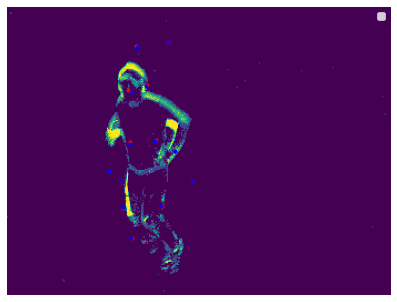

In [71]:
viz.plot_skeleton_2d(b_x[0].squeeze(),b_y['2d_joints'][0], pred_sk.get_2d_points(260, 346, extrinsic_matrix=b_y['M'][0], intrinsic_matrix=b_y['camera'][0]))

### DHP19


In [16]:
# path = "/home/gianscarpe/dev/event-based-monocular-hpe/timecount_dhp19/exps_MargiposeEstimator/cross-subject/03-20-08-54_exp_resnet50_pretrained_True_stages_3/checkpoints/"
path = r'D:\Dataset\DVS\dhp19\pretrained_model\dhp19_constantcount\checkpoints'
model = utilities.load_model(path, "MargiposeEstimator", core=dhpcore).eval().double()

Loading training
Loading from ...  D:\Dataset\DVS\dhp19\pretrained_model\dhp19_constantcount\checkpoints\epoch=19-val_loss=0.09.ckpt


In [17]:
factory = Joints3DConstructor()
factory.set_dataset_core(dhpcore)
train, val, test = factory.get_datasets({'apply':{}}, {'apply':{}})

In [18]:
loader = iter(torch.utils.data.DataLoader(test, batch_size=1, shuffle=True))

In [19]:
b_x, b_y = next(loader)

e:\GitHub\lifting_events_to_3d_hpe\notebooks\../scripts\experimenting\utils\visualization.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
No handles with labels found to put in legend.


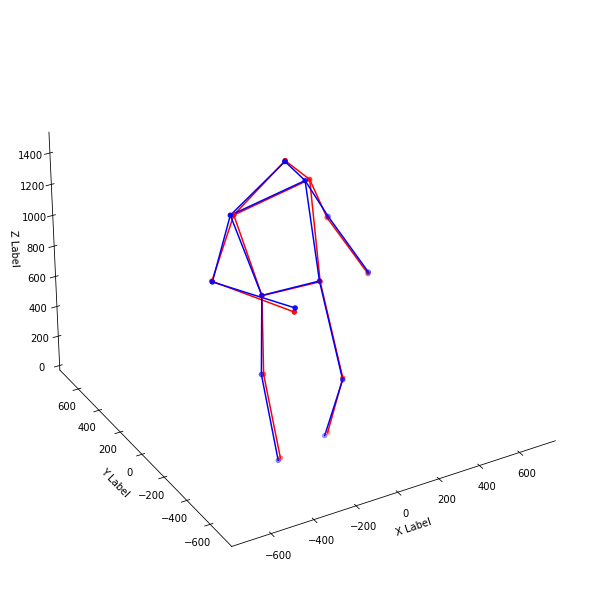

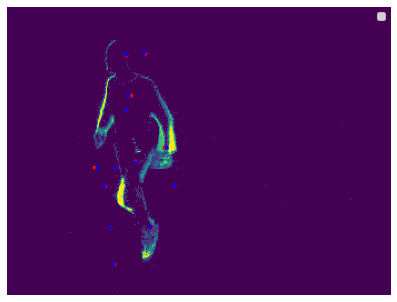

In [27]:
def plot_next(loader):
    b_x, b_y = next(loader)
    preds, outs = model(b_x.permute(0, -1, 1, 2))
    pred_sk = Skeleton(preds[0].detach().numpy()).denormalize(260, 346, camera=b_y['camera'][0], z_ref=b_y['z_ref'][0]).reproject_onto_world(b_y['M'][0])
    plot_skeleton_3d(Skeleton(b_y['xyz'][0]), pred_sk)
    gt_joints = torch.stack([b_y['2d_joints'][0][:, 0], b_y['2d_joints'][0][:, 1]], 1)
    pred_joints = pred_sk.get_2d_points(260, 346, extrinsic_matrix=b_y['M'][0], intrinsic_matrix=b_y['camera'][0])

    pred_joints = np.stack([pred_joints[:, 0], pred_joints[:, 1]], 1)
    plot_skeleton_2d(b_x[0].squeeze(), gt_joints, pred_joints)

plot_next(loader=loader)